Import Necessary Library

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GlobalAveragePooling1D, Dense, Dropout, Bidirectional # Import Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import random
import numpy as np
import pandas as pd

Load the dataset

In [2]:
# Load dataset
data = pd.read_csv('/content/weather_classification_data_v3.csv')

Check the dataset

In [3]:
data.head()

,text,label
0,What should I wear for a sunny day?,sunny
1,Any outfit tips for It's really warm?,hot
2,Any outfit tips for It's snowing?,snowy
3,What do you suggest I put on for It's snowing?,snowy
4,What do you suggest I put on for during snowfall?,snowy


In [4]:
len(data)

60000

In [5]:
data.duplicated().sum()

59210

In [6]:
data.isnull().sum()

,0
text,0
label,0


In [7]:
data.drop_duplicates(inplace=True)

In [8]:
len(data)

790

Making sure the NLTK data is downloaded

In [9]:
# Ensure NLTK data is downloaded
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Initialize Neccesary NLTK tools

In [10]:
# Initialize NLTK tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

Function to preprocess the text

In [11]:
# Text preprocessing function
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    tokens = [word for word in tokens if word.isalnum()]  # Remove non-alphanumeric tokens
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize tokens
    return " ".join(tokens)

In [12]:
# Preprocess the dataset
data['text'] = data['text'].apply(preprocess_text)

In [13]:
data

,text,label
0,wear sunny day,sunny
1,outfit tip really warm,hot
2,outfit tip snowing,snowy
3,suggest put snowing,snowy
4,suggest put snowfall,snowy
...,...,...
41137,give outfit advice heat,hot
41255,would suit weather best heavy snowfall,snowy
41298,would suggest attire wintry snowy day,snowy
41457,ideal wear downpour,rainy


Function to augment the data

In [14]:
# Augment data
def augment_sentence(sentence):
    synonyms = {
        "sunny": ["bright", "clear"],
        "rainy": ["wet", "drizzly"],
        "cold": ["chilly", "freezing"],
        "snowy": ["wintry", "icy"],
        "hot": ["warm", "scorching"]
    }
    words = sentence.split()
    new_words = [random.choice(synonyms[word]) if word in synonyms else word for word in words]
    return " ".join(new_words)


In [15]:
augmented_data = []
for index, row in data.iterrows():
    augmented_data.append((augment_sentence(row['text']), row['label']))

Concat and augment the data

In [16]:
# Concatenate original and augmented data
data = pd.concat([data, pd.DataFrame(augmented_data, columns=['text', 'label'])], ignore_index=True)

need to extract features and labels

In [17]:
# Extract features and labels
X = data['text'].values
y = data['label'].values


In [18]:
X

array(['wear sunny day', 'outfit tip really warm', 'outfit tip snowing',
       ..., 'would suggest attire wintry wintry day',
       'ideal wear downpour', 'would suggest attire warm sunlight'],
      dtype=object)

In [19]:
y

array(['sunny', 'hot', 'snowy', ..., 'snowy', 'rainy', 'sunny'],
      dtype=object)

Encode the labels

In [20]:
# Encode labels
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y)
y_encoded = np.array(label_tokenizer.texts_to_sequences(y)) - 1

Tokenize the input

In [21]:
# Tokenize input text
tokenizer = Tokenizer(num_words=1000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, padding='post')

In [22]:
X_padded

array([[  4,  32,   3, ...,   0,   0,   0],
       [  2,   9, 101, ...,   0,   0,   0],
       [  2,   9,  60, ...,   0,   0,   0],
       ...,
       [  7,  10,  27, ...,  40,   3,   0],
       [ 13,   4,  79, ...,   0,   0,   0],
       [  7,  10,  27, ...,  99,   0,   0]], dtype=int32)

Split into training and validation with 25% splitting

In [23]:
# Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_encoded, test_size=0.25, random_state=42)

Make custom callback just in case we need it

In [24]:
# Custom callback to stop training at accuracy threshold
class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, accuracy_threshold=0.95):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.accuracy_threshold = accuracy_threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get("accuracy") >= self.accuracy_threshold and logs.get("val_accuracy") >= self.accuracy_threshold:
            print(f"\nStopping training as accuracy and val_accuracy have reached {self.accuracy_threshold * 100}%")
            self.model.stop_training = True

In [25]:
early_stopping_accuracy = EarlyStoppingAtAccuracy()

Define the model

In [26]:
# Define the model with Bidirectional LSTM
model = Sequential([
    Embedding(input_dim=1000, output_dim=64),  # Embedding layer
    Bidirectional(LSTM(64, return_sequences=True)),  # Bidirectional LSTM
    Dropout(0.3),  # Dropout for regularization
    GlobalAveragePooling1D(),  # Global Average Pooling layer
    Dense(32, activation='relu'),  # Dense layer
    Dropout(0.2),  # Additional regularization
    Dense(len(label_tokenizer.word_index), activation='softmax')  # Output layer
])


Compile the model with optimizer,loss function, and metrics

In [27]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

train the model with model.fit

In [28]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=12,  # Adjusted epochs for efficiency
    validation_data=(X_test, y_test),
    #callbacks=[early_stopping_accuracy]
)


Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2315 - loss: 1.6035 - val_accuracy: 0.5342 - val_loss: 1.5481
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6573 - loss: 1.4334 - val_accuracy: 0.9089 - val_loss: 0.6132
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8767 - loss: 0.4771 - val_accuracy: 0.9646 - val_loss: 0.1460
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9544 - loss: 0.1492 - val_accuracy: 0.9696 - val_loss: 0.1100
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9910 - loss: 0.0621 - val_accuracy: 0.9899 - val_loss: 0.0313
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9878 - loss: 0.0409 - val_accuracy: 0.9899 - val_loss: 0.0305
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9327 - loss: 0.2704 - val_accuracy: 0.9696 - val_loss: 0.1130
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9744 - loss: 0.0865 - val_accuracy: 0.9924 - v

Evaluate the loss and accuracy of the X_test and y_test

In [29]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9890 - loss: 0.0259 
Test Loss: 0.017156356945633888, Test Accuracy: 0.9924050569534302


Visualize the model

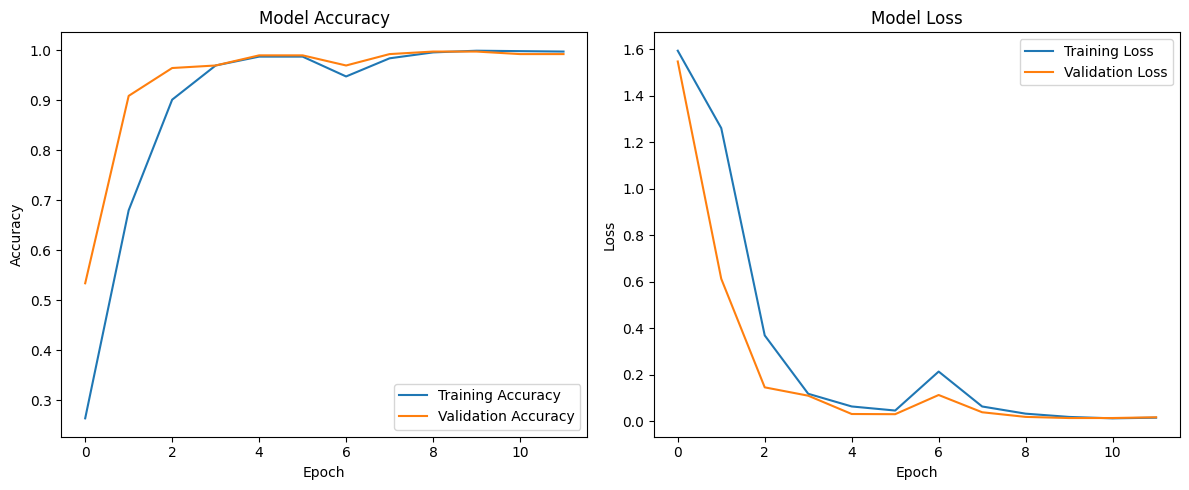

In [30]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Inspect the model architecture

In [31]:
# Display the model summary instead
print("Model Summary:")
model.summary()

# If you want to inspect model inputs/outputs, you can use:
print("Model Inputs:", model.inputs)
print("Model Outputs:", model.outputs)

Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 7, 64)               │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 7, 128)              │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,025 (1.54 MB)

 Trainable params: 134,341 (524.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 268,684 (1.02 MB)

Model Inputs: [<KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor>]
Model Outputs: [<KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_7>]


Download the tokenizer

In [32]:
#save the tokenizer
import pickle

# Assuming 'tokenizer' is the tokenizer object you've trained
with open('/content/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print("Tokenizer saved!")

Tokenizer saved!


Also save the model in .h5 format

In [33]:
model.save('/content/my_model2.h5')  # Saves in HDF5 format